<a href="https://colab.research.google.com/github/bartiralira/DeepLearning/blob/main/9_1_Eletrical_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Participantes (RM - NOME):***<br>
Vitor Luiz Carvalhal - 337129<br>
Ricardo Fabbro Antonelli - 339505<br>
Bartira Lira Lafiandre - 340177<br>
Tiago Batista Pessoa - 339575<br>

## Exercício 9.1
---
Utilizando o dataset Eletrical_Production.csv (disponível no repositório da disciplina) faça uma previsão de série temporal utilizando LSTM para
prever os últimos 20% de dias do dataset (conjunto de treino)<br>
Instruções Gerais:<br>
>É permitido usar outras abordagens e arquiteturas de LSTM;<br>
>Não é permitido o uso de modelos pré treinados<br>
>O Aluno pode escolher a janela de tempo para compor o conjunto de
treinamento.

## 0. Bibbliotecas e afins


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error

import plotly.express as px

In [2]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [3]:
# monta google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Analisando os dados

In [4]:
np.random.seed(7)

#Carrega o dataset
dataframe = read_csv("https://telescopeinstorage.blob.core.windows.net/datasets/Eletrical_Production.csv", usecols=[1], engine='python')
dataframe.head(150)

,IPG2211A2N
0,3.3842
1,3.4100
2,3.4875
3,3.5133
4,3.5133
...,...
145,10.2817
146,10.2817
147,10.2559
148,10.0492


In [5]:
dataframe.shape

(964, 1)

In [6]:
X = dataframe.values
X = X.astype('float32')

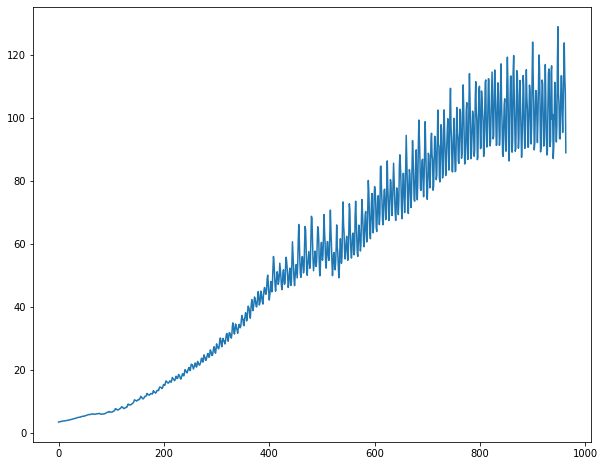

In [7]:
plt.figure(figsize=(10,8))
plt.plot(dataframe)

## 2. Preparando os dados para o modelo

In [8]:
#Selecionei uma faixa de tempo a partir de 500. Isso evitará termo enviesamento pelo historico muito antigo.
X = X[350:len(X),:]

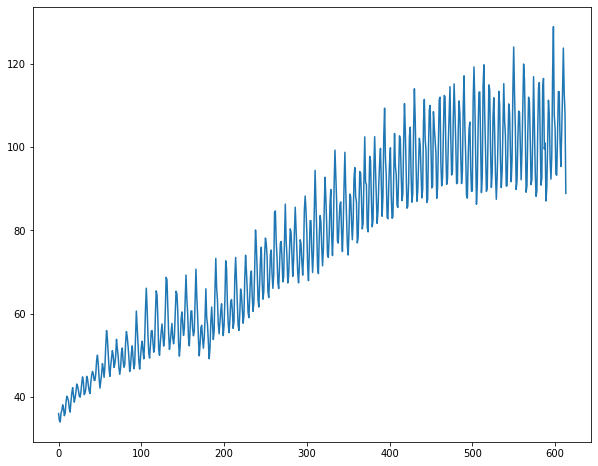

In [9]:
plt.figure(figsize=(10,8))
plt.plot(X)

In [10]:
#Normaliza o dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
#Separando em conjunto de treino e de teste. 80% para treino e 20% para teste
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

train = X[0:train_size,:]
test =  X[train_size:len(X),:]

print(train.shape)
print(test.shape)


(491, 1)
(123, 1)


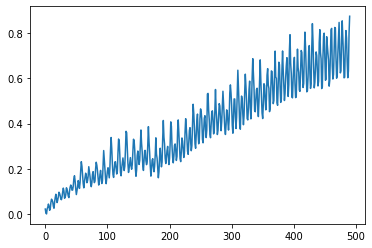

In [12]:
#checando como ficou o conjunto de treino
plt.plot(train)

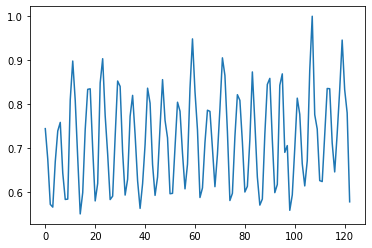

In [13]:
#checando como ficou o conjunto de teste
plt.plot(test)

In [14]:
# quantidade de atrasos
look_back = 3

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

#gerando conjunto de validacao
(X_train, x_valid) = X_train[100:], X_train[:100]
(y_train, y_valid) = y_train[100:], y_train[:100]

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))


In [15]:
print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')
print(x_valid.shape, 'validation samples')

(487, 3, 1) train samples
(119, 3, 1) test samples
(100, 3, 1) validation samples


In [16]:
X_train.shape

(487, 3, 1)

## 3. Modelagem

In [17]:
# Cria e treina a rede LSTM
model = Sequential()
model.add(LSTM(8, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='Adamax', metrics = ['mae'])

>>Vamos adicionar model checkpoint para guardar a melhor predicao pois treinamento em 100 epocas

In [18]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Dataset/modeloPredicaoEletrica.hdf5', verbose=1,  save_best_only=True, monitor='val_mae') #

hist = model.fit(X_train, y_train, batch_size=1, epochs=100,validation_data=(x_valid, y_valid), callbacks=[checkpointer], verbose=1, shuffle=True)


Epoch 1/100
487/487 [==============================] - 19s 4ms/step - loss: 0.1341 - mae: 0.2936 - val_loss: 0.0406 - val_mae: 0.1965

Epoch 00001: val_mae improved from inf to 0.19647, saving model to /content/drive/MyDrive/Dataset/modeloPredicaoEletrica.hdf5
Epoch 2/100
487/487 [==============================] - 1s 2ms/step - loss: 0.0193 - mae: 0.1178 - val_loss: 0.0254 - val_mae: 0.1547

Epoch 00002: val_mae improved from 0.19647 to 0.15468, saving model to /content/drive/MyDrive/Dataset/modeloPredicaoEletrica.hdf5
Epoch 3/100
487/487 [==============================] - 1s 2ms/step - loss: 0.0129 - mae: 0.0939 - val_loss: 0.0079 - val_mae: 0.0821

Epoch 00003: val_mae improved from 0.15468 to 0.08214, saving model to /content/drive/MyDrive/Dataset/modeloPredicaoEletrica.hdf5
Epoch 4/100
487/487 [==============================] - 1s 2ms/step - loss: 0.0099 - mae: 0.0836 - val_loss: 0.0053 - val_mae: 0.0653

Epoch 00004: val_mae improved from 0.08214 to 0.06530, saving model to /conte

## 4. Avaliação do modelo e aplicação no conjunto de teste

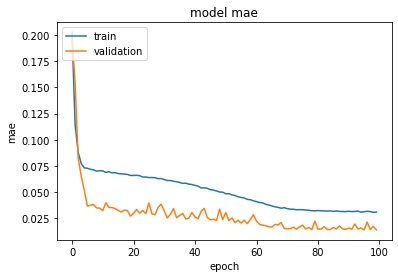

In [19]:
plt.figure(1)
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
#carrega o melhor modelo
model = load_model("/content/drive/MyDrive/Dataset/modeloPredicaoEletrica.hdf5")

In [21]:
#Acuracidade do conjunto de treino
score = model.evaluate(X_train, y_train, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.031181558966636658


In [22]:
# Realiza as Predições no conjunto de treino e de teste
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)


In [23]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])


In [24]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 4.05 RMSE
Test Score: 7.07 RMSE


In [25]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [26]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

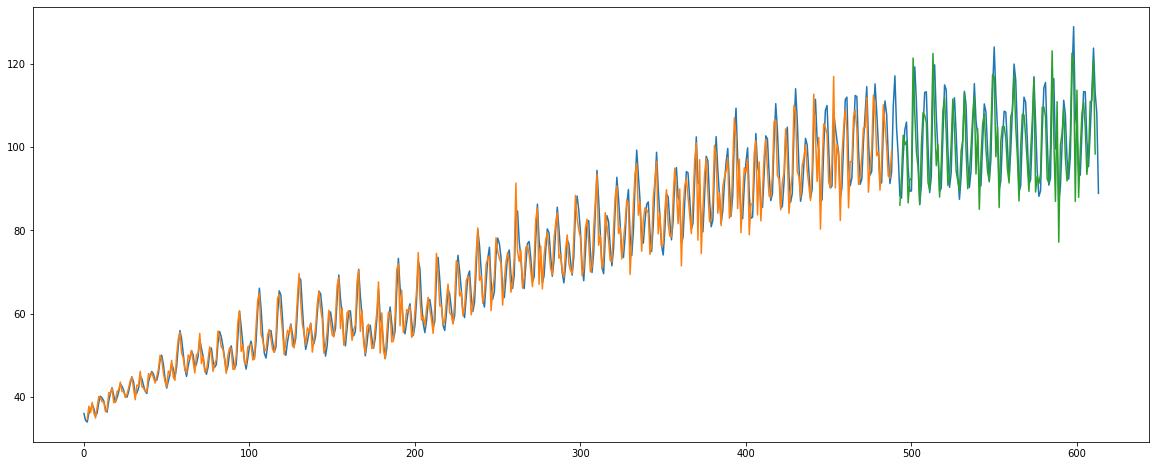

In [27]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()